# Roberta score calculateing among databases 2.0

2020/11/8

Student: Xuanyu Su                                                                 
Supervisor: Isar Nejadgholi

In this version, we mainly modified the y-axis of the distance comparison graph, change the y-axis from numbers of words in each sentence into the percentages, which make the image distribution more even and more easy to compare.
_________________________________________________________________________________________________________________

in this module we are trying to explore the Roberta score among three data sets(ac, toxicity and gab) and to observe the distribution of these three datasets. 

Roberta score is extracted from the final linear layer of Roberta model, the original data is [x, y](y is negative). The final score is the sum of x and y. In this case, the score represents the pos/neg trendency and model discrimination range.

In [20]:
import json

# read file
with open('EA/RoBERTa/special_tokens_map.json', 'r',encoding='utf-8') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)

In [21]:
obj

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}

In [13]:
import json

# read file
with open('EA/RoBERTa/tokenizer_config.json', 'r',encoding='utf-8') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)

In [14]:
obj

{'max_len': 512}

In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

In [2]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [3]:
source_folder = 'Data'
destination_folder = 'Model'

In [4]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [5]:
# wōrd embedding
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('toxicity', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='Train_comment_toxity.csv', validation='Val_comment_toxity.csv',
                                           test='Test_comment_toxity.csv', format='CSV', fields=fields, skip_header=True)


train_iter_toxity = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_toxity = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_toxity = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [6]:
def embedding_on_GAB(test_file, text_name,label_name):
    # Model parameter
    MAX_SEQ_LEN = 128
    # Set tokenizer hyperparameters.
    BATCH_SIZE = 8
    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


    # Define columns to read.
    label_field = Field(sequential=False, use_vocab=False, batch_first=True)
    text_field = Field(use_vocab=False, 
                       tokenize=tokenizer.encode, 
                       include_lengths=False, 
                       batch_first=True,
                       fix_length=MAX_SEQ_LEN, 
                       pad_token=PAD_INDEX, 
                       unk_token=UNK_INDEX)

    fields = [(text_name, text_field),(label_name, label_field)]


    # TabularDataset

    train, valid, test = TabularDataset.splits(path=source_folder,train=test_file, validation=test_file,
                                               test=test_file, format='CSV', fields=fields, skip_header=True)


    train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.Text),
                                device=device, train=True, sort=True, sort_within_batch=True)
    valid_iter = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.Text),
                                device=device, train=True, sort=True, sort_within_batch=True)
    test_iter = Iterator(test, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)
 
    return train_iter, valid_iter, test_iter

In [7]:
Text_field = 'Text'
label_field = 'Hate'
file_field = "final_GAB.csv"
train_iter_GAB, valid_iter_GAB, GAB_embedding = embedding_on_GAB(file_field,Text_field ,label_field)

In [8]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [9]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x1 = self.d1(x)
        x2 = self.l1(x1)
        x3 = self.bn1(x2)
        x4 = torch.nn.Tanh()(x3)
        x5 = self.d2(x4)
        x6 = self.l2(x5)
        
        return x6

In [75]:
output_path = 'Model_roberta'
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

0.08447376631685106

In [43]:
def Finetuning(model, 
             optimizer, 
             train_iter, 
             valid_iter,
             valid_period,
             scheduler = None,
             num_epochs = 5):
    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    # Train loop
    for epoch in range(num_epochs):
        count = 0
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
        
            y_pred = model(input_ids=source,  
                           attention_mask=mask)

            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
#             print('batch_no [{}/{}]:'.format(count, int(len(train_iter))),'training_loss:',loss)
            count+=1
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
    
    print('finetuning done!')
    return model

# Toxicity

In [12]:
NUM_EPOCHS = 3
steps_per_epoch = len(train_iter_toxity)
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                          num_training_steps=steps_per_epoch*NUM_EPOCHS)
print("======================= Start finetuning ==============================")
model_fintuned_Toxity = Finetuning(model=model,
         train_iter=train_iter_toxity, 
         valid_iter=valid_iter_toxity,
         valid_period=len(train_iter_toxity),
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

======================= Start finetuning ==============================
Epoch [1/3], global step [11962/35886], PT Loss: 0.0661, Val Loss: 0.0858
Epoch [2/3], global step [23924/35886], PT Loss: 0.0700, Val Loss: 0.0893
Epoch [3/3], global step [35886/35886], PT Loss: 0.0704, Val Loss: 0.0895
finetuning done!


In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# Evaluation Function
import seaborn as sns
def generate(model, test_loader):
    y_pred = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (source, target), _ in tqdm(test_loader):
                mask = (source != PAD_INDEX).type(torch.uint8)
                output = model(source, attention_mask=mask)
                y_prob.extend(output.tolist())
    return y_prob

In [15]:
from tqdm import tqdm
prediction_list = generate(model_fintuned_Toxity , test_iter_toxity)

100%|████████████████████████████████████████████████████████████████████████████| 11962/11962 [10:34<00:00, 18.86it/s]


In [16]:
x_Toxity = [item[0] for item in prediction_list]
y_Toxity = [item[1] for item in prediction_list]

In [17]:
prediction_list[0:8]

[[3.215059280395508, -3.961904764175415],
 [3.0461246967315674, -3.6783156394958496],
 [3.091057777404785, -3.7532103061676025],
 [2.5858280658721924, -3.037609815597534],
 [2.5250821113586426, -2.972714900970459],
 [3.0994489192962646, -3.770008087158203],
 [3.1379952430725098, -3.8188059329986572],
 [2.739901542663574, -3.2612123489379883]]

In [18]:
from tqdm import tqdm
final_point = []
for item in tqdm(prediction_list):
       final_point.append(sum(item))

100%|███████████████████████████████████████████████████████████████████████| 95692/95692 [00:00<00:00, 1571673.24it/s]


In [19]:
import pandas as pd
toxity = pd.read_csv('Data/Train_comment_toxity.csv',sep = ',')

In [20]:
toxity.head()

,comment,toxicity
0,this one can make an analogy in mathematical t...,0
1,clarification for you and zundark s right i...,0
2,this is such a fun entry devotchka i once had...,0
3,i fixed the link i also removed homeopathy ...,0
4,if they are indisputable then why does the ...,0


In [21]:
length_toxity = []
for sentence in tqdm(toxity['comment']):
    length_toxity.append(len(sentence.split()))

100%|████████████████████████████████████████████████████████████████████████| 95692/95692 [00:00<00:00, 207664.32it/s]


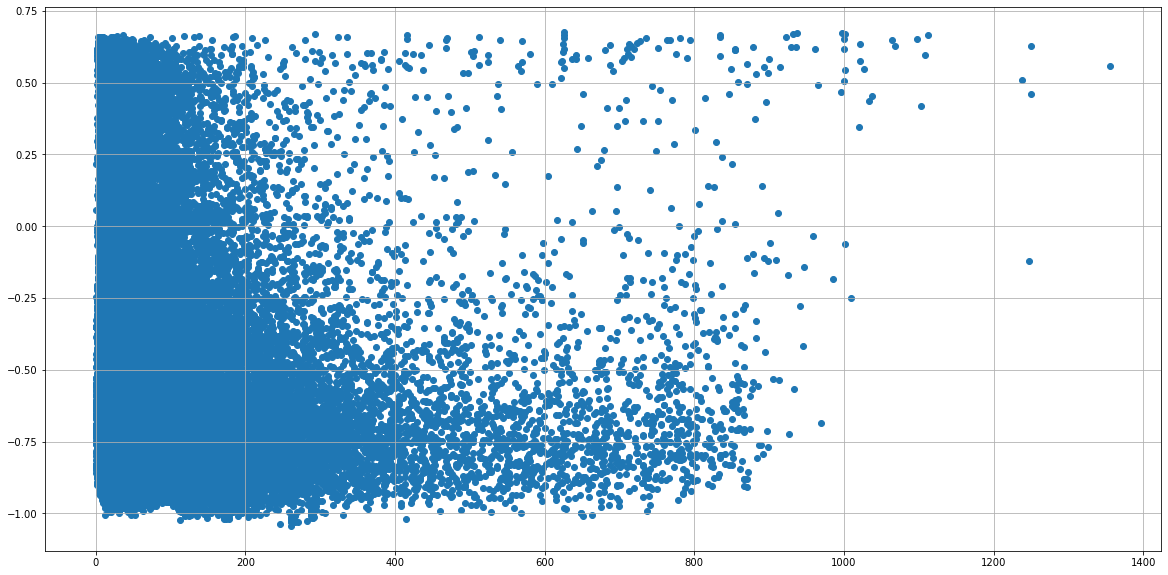

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.scatter(length_toxity, final_point)
plt.grid()
plt.show()

# GAB

In [65]:
NUM_EPOCHS = 3
steps_per_epoch = len(train_iter_GAB)
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                          num_training_steps=steps_per_epoch*NUM_EPOCHS)



print("======================= Start finetuning ==============================")
model_fintuned_GAB = Finetuning(model=model,
         train_iter=train_iter_GAB, 
         valid_iter=valid_iter_GAB,
         valid_period=len(train_iter_GAB),
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

======================= Start finetuning ==============================
Epoch [1/3], global step [3459/10377], PT Loss: 0.4998, Val Loss: 0.3918
Epoch [2/3], global step [6918/10377], PT Loss: 0.3450, Val Loss: 0.3233
Epoch [3/3], global step [10377/10377], PT Loss: 0.3152, Val Loss: 0.3138
finetuning done!


In [66]:
prediction_list_GAB = generate(model_fintuned_GAB , GAB_embedding)

100%|██████████████████████████████████████████████████████████████████████████████| 3459/3459 [03:05<00:00, 18.61it/s]


In [67]:
x_GAB = [item[0] for item in prediction_list_GAB]
y_GAB = [-item[1] for item in prediction_list_GAB]

In [68]:
from tqdm import tqdm
final_point_GAB = []
for item in tqdm(prediction_list_GAB):
       final_point_GAB.append(sum(item))

100%|███████████████████████████████████████████████████████████████████████| 27665/27665 [00:00<00:00, 1631750.65it/s]


In [69]:
GAB_final = pd.read_csv("Data/final_GAB.csv",sep=',')

In [70]:
GAB_final.head()

,Text,Hate,length
0,ah the psyops antifa crew is back that s how i...,0,15
1,get the new android app update released today ...,0,9
2,study google pushes liberal news in top 5 sear...,0,10
3,claiming bias against conservatives has filed...,1,17
4,these companies are run by sociopaths he said...,0,37


In [71]:
length_GAB = []
import numpy as np
for sentence in tqdm(GAB_final['Text']):
    if pd.isnull(sentence):
        length_GAB.append(0)
    else:
        length_GAB.append(len(sentence.split()))

100%|████████████████████████████████████████████████████████████████████████| 27665/27665 [00:00<00:00, 426552.20it/s]


In [72]:
prediction_list_GAB[0:8]

[[1.4620505571365356, -1.7568364143371582],
 [1.6659691333770752, -2.0410637855529785],
 [1.3526499271392822, -1.6177304983139038],
 [1.2721537351608276, -1.5068734884262085],
 [0.8105629682540894, -0.9147294759750366],
 [1.038764238357544, -1.2063137292861938],
 [1.4620438814163208, -1.771212100982666],
 [1.052538514137268, -1.2280110120773315]]

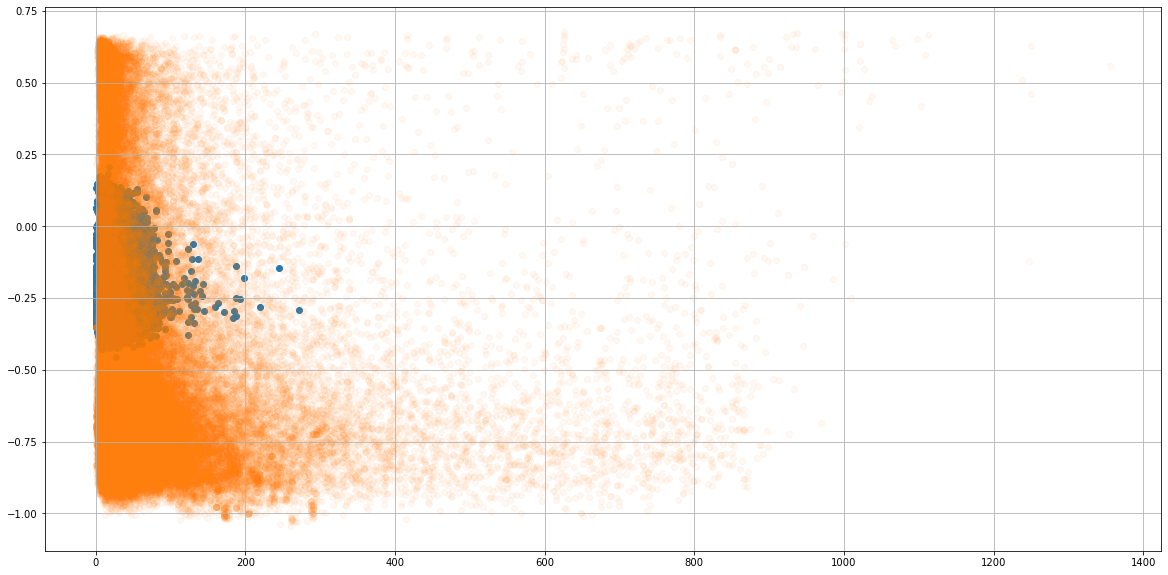

In [73]:
plt.figure(figsize=(20,10))
plt.scatter(length_GAB, final_point_GAB)
plt.scatter(length_toxity, final_point,alpha=0.05)
plt.grid()
plt.show()

# cross test on 2400 covid

In [76]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('toxicity', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='test5.csv', validation='test5.csv',
                                           test='test5.csv', format='CSV', fields=fields, skip_header=True)


train_iter_2400 = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_2400 = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_2400 = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [77]:
NUM_EPOCHS = 3
steps_per_epoch = len(train_iter_GAB)
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                          num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start finetuning ==============================")
model_fintuned_2400 = Finetuning(model=model,
         train_iter=train_iter_2400, 
         valid_iter=valid_iter_2400,
         valid_period=len(train_iter_2400),
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

======================= Start finetuning ==============================
Epoch [1/3], global step [290/870], PT Loss: 0.9153, Val Loss: 0.9066
Epoch [2/3], global step [580/870], PT Loss: 0.8550, Val Loss: 0.8878
Epoch [3/3], global step [870/870], PT Loss: 0.8276, Val Loss: 0.8563
finetuning done!


In [78]:
prediction_list_2400 = generate(model_fintuned_2400 , test_iter_2400)

100%|████████████████████████████████████████████████████████████████████████████████| 290/290 [00:15<00:00, 18.44it/s]


In [79]:
from tqdm import tqdm
final_point_2400 = []
for item in tqdm(prediction_list_2400):
       final_point_2400.append(sum(item))

100%|█████████████████████████████████████████████████████████████████████████| 2319/2319 [00:00<00:00, 1163050.46it/s]


In [80]:
t2400_final = pd.read_csv("Data/test5.csv",sep=',')

In [81]:
length_2400 = []
for sentence in tqdm(t2400_final['comment']):
    if pd.isnull(sentence):
        length_2400.append(0)
    else:
        length_2400.append(len(sentence.split()))

100%|██████████████████████████████████████████████████████████████████████████| 2319/2319 [00:00<00:00, 290632.29it/s]


# cross test on Attack comment 

In [38]:
temp1 = pd.read_csv('Data/Train_comment.csv',sep = ',')
temp2 = pd.read_csv('Data/Val_comment.csv',sep = ',')

In [48]:
temp1 = temp1.drop(columns=['Unnamed: 0'])
temp2 = temp2.drop(columns=['Unnamed: 0'])

In [50]:
temp2.head()

,comment,attack
0,next maybe you could work on being less conde...,0
1,if you ever claimed in a judaic studies progr...,0
2,my apologies i m english i watch cricket i k...,0
3,gets far more tendentious yet,0
4,that s another relevant empirical question i...,0


In [51]:
temp1.to_csv('Data/Train_comment.csv',index=False,header=True)
temp2.to_csv('Data/Val_comment.csv',index=False,header=True)

In [52]:
temp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69526 entries, 0 to 69525
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  69526 non-null  object
 1   attack   69526 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [53]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('attack', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='Train_comment.csv', validation='Val_comment.csv',
                                           test='Train_comment.csv', format='CSV', fields=fields, skip_header=True)


train_iter_AC = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_AC = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_AC = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [54]:
NUM_EPOCHS = 3
steps_per_epoch = len(train_iter_AC)
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                          num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start finetuning ==============================")
model_fintuned_AC = Finetuning(model=model, train_iter=train_iter_AC , 
         valid_iter=valid_iter_AC,
         valid_period=len(train_iter_AC),
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

======================= Start finetuning ==============================
Epoch [1/3], global step [8691/26073], PT Loss: 0.1184, Val Loss: 0.1160
Epoch [2/3], global step [17382/26073], PT Loss: 0.1189, Val Loss: 0.1200
Epoch [3/3], global step [26073/26073], PT Loss: 0.1197, Val Loss: 0.1176
finetuning done!


In [55]:
prediction_list_AC = generate(model_fintuned_AC , test_iter_AC)

100%|██████████████████████████████████████████████████████████████████████████████| 8691/8691 [07:48<00:00, 18.53it/s]


In [57]:
from tqdm import tqdm
final_point_AC = []
for item in tqdm(prediction_list_AC):
       final_point_AC.append(sum(item))

100%|███████████████████████████████████████████████████████████████████████| 69526/69526 [00:00<00:00, 1584346.21it/s]


In [58]:
AC_final = pd.read_csv("Data/Train_comment.csv",sep=',')

In [59]:
length_AC = []
for sentence in tqdm(AC_final['comment']):
    if pd.isnull(sentence):
        length_AC.append(0)
    else:
        length_AC.append(len(sentence.split()))

100%|████████████████████████████████████████████████████████████████████████| 69526/69526 [00:00<00:00, 182014.34it/s]


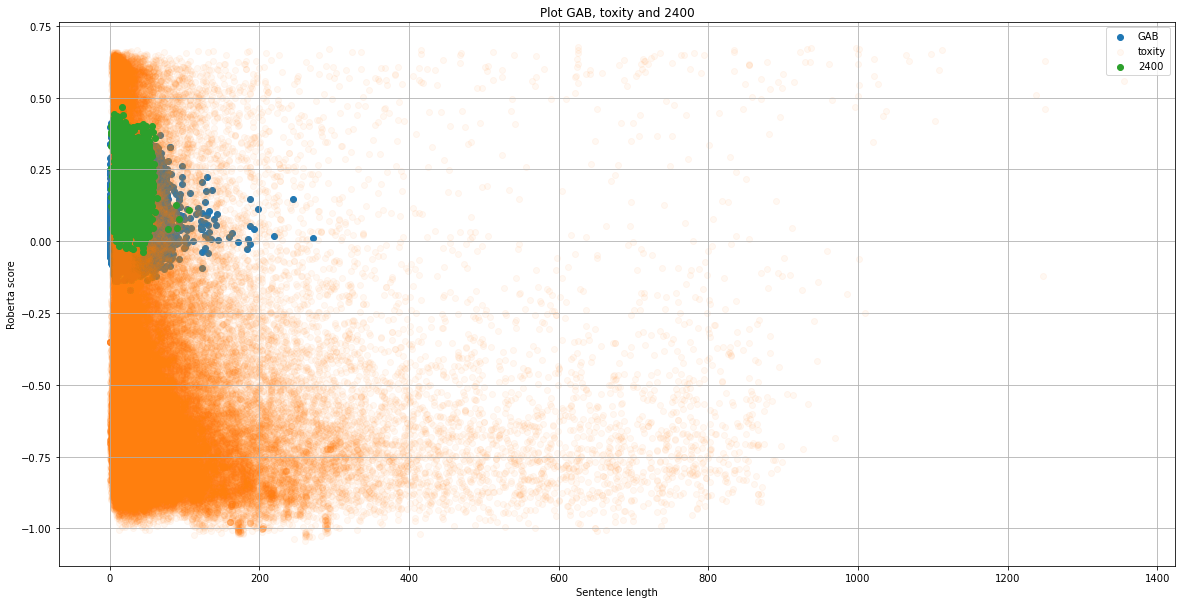

In [60]:
plt.figure(figsize=(20,10))
plt.scatter(length_GAB, final_point_GAB, label = 'GAB')
plt.scatter(length_toxity, final_point,alpha=0.05, label = 'toxity')
plt.scatter(length_2400, final_point_2400, label = '2400')
plt.title('Plot GAB, toxity and 2400')
plt.grid()
plt.ylabel('Roberta score')
plt.xlabel('Sentence length')
plt.legend()
plt.show()

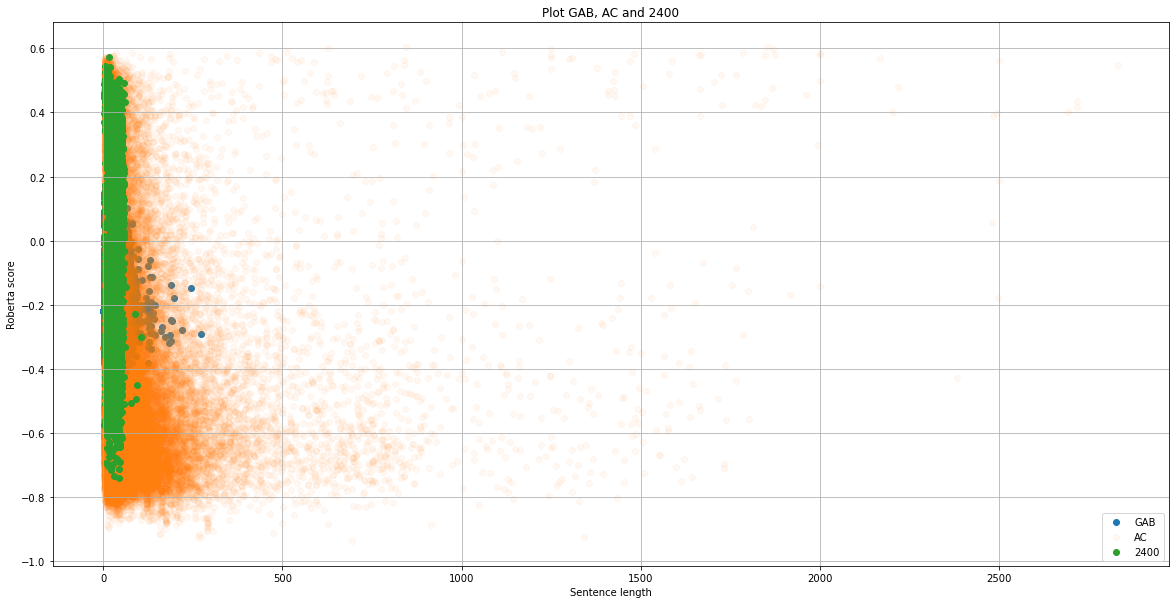

In [95]:
plt.figure(figsize=(20,10))
plt.scatter(length_GAB, final_point_GAB, label = 'GAB')
plt.scatter(length_AC, final_point_AC, label = 'AC', alpha= 0.05)
plt.scatter(length_2400, final_point_2400, label = '2400')
plt.grid()
plt.title('Plot GAB, AC and 2400')
plt.ylabel('Roberta score')
plt.xlabel('Sentence length')
plt.legend()
plt.show()

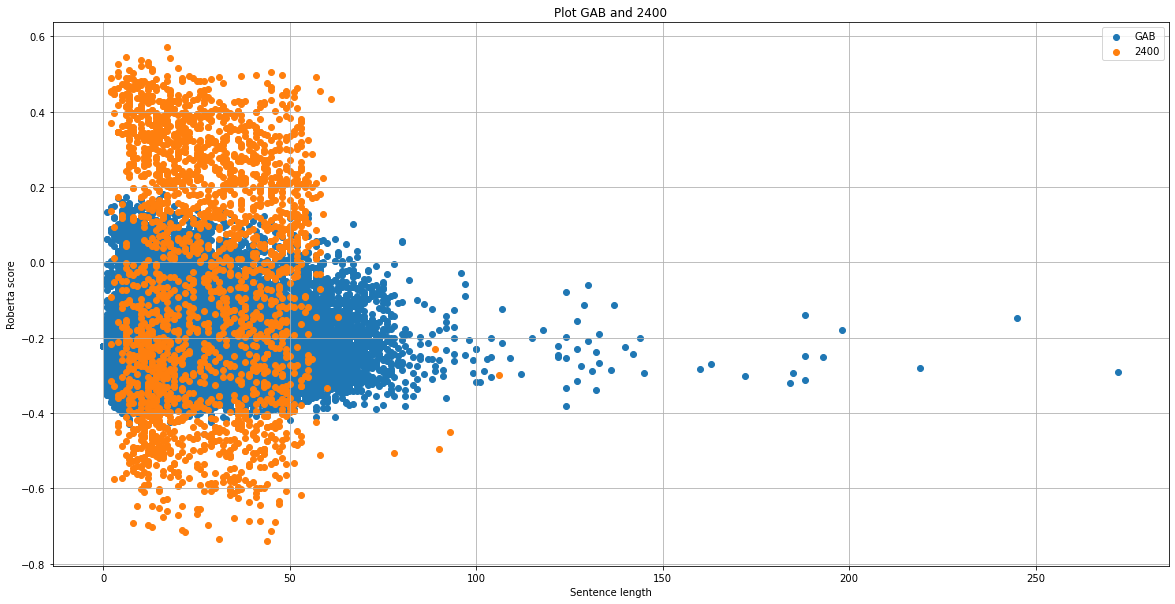

In [94]:
plt.figure(figsize=(20,10))
plt.scatter(length_GAB, final_point_GAB, label = 'GAB')
plt.scatter(length_2400, final_point_2400, label = '2400')
plt.grid()
plt.title('Plot GAB and 2400')
plt.ylabel('Roberta score')
plt.xlabel('Sentence length')
plt.legend()
plt.show()

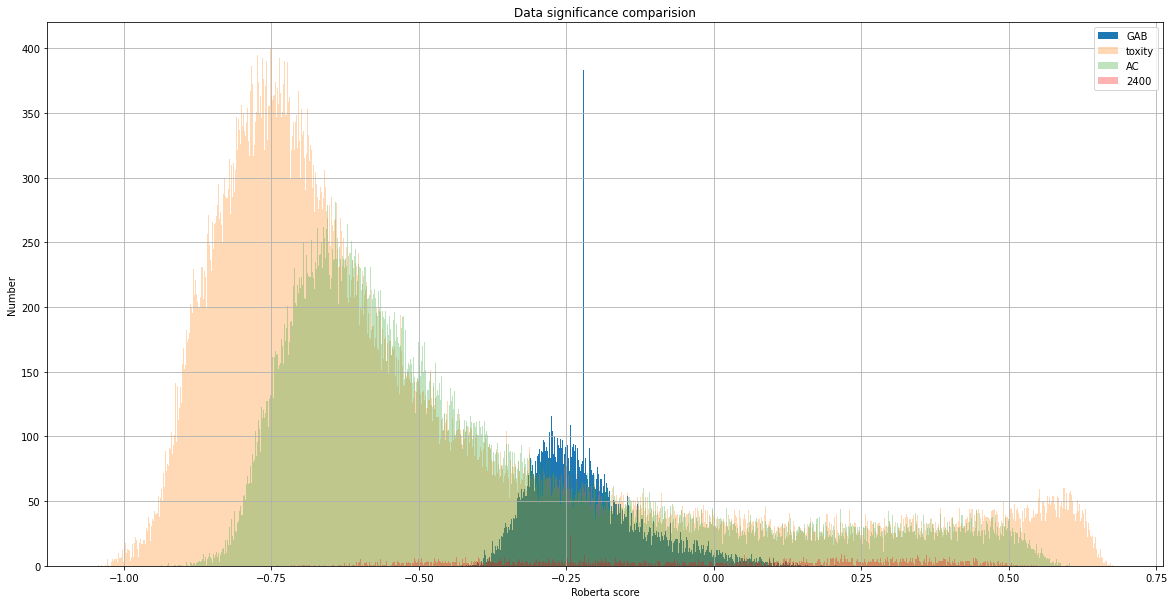

In [97]:
plt.figure(figsize=(20,10))
plt.hist(final_point_GAB, label= 'GAB', bins=1000)
plt.hist(final_point, label = 'toxity', bins = 1000,alpha = 0.3)
plt.hist(final_point_AC,label = 'AC', bins = 1000,alpha = 0.3)
plt.hist(final_point_2400, label = '2400', bins = 1000,color='r', alpha = 0.3)
plt.title('Data significance comparision')
plt.grid()
plt.ylabel('Number')
plt.xlabel('Roberta score')
plt.legend()
plt.show()

# distance comparison graph after modifying the y-axis

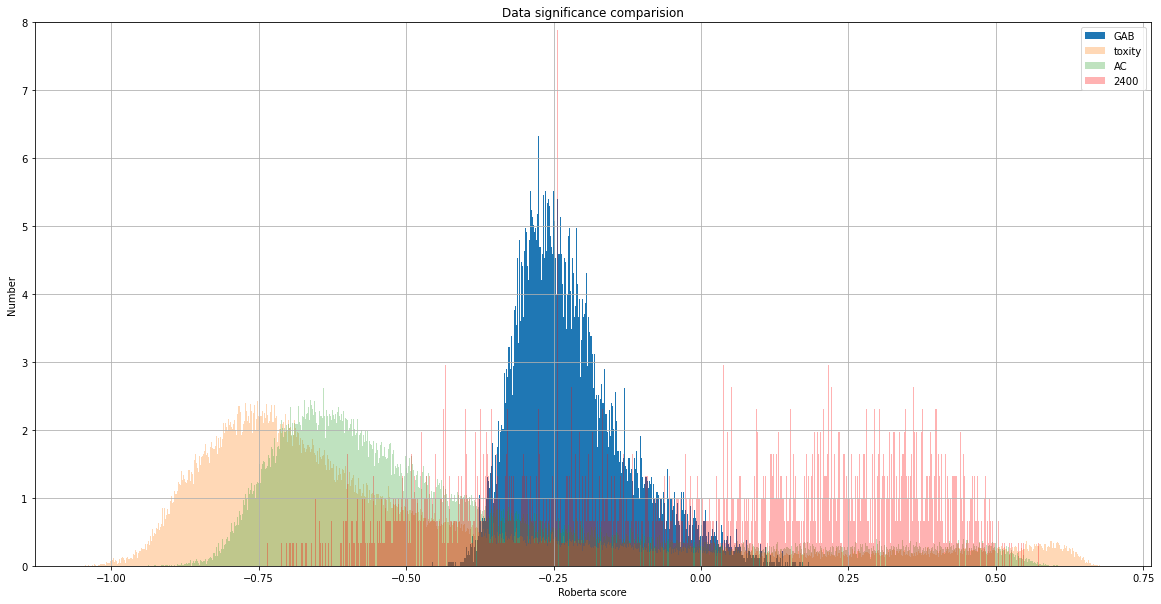

In [93]:
plt.figure(figsize=(20,10))
plt.hist(final_point_GAB, density = True, label= 'GAB', bins=1000)
plt.hist(final_point,density = True, label = 'toxity', bins = 1000,alpha = 0.3)
plt.hist(final_point_AC,label = 'AC', bins = 1000,alpha = 0.3,density = True)
plt.hist(final_point_2400, label = '2400', bins = 1000,color='r',density=True, alpha = 0.3)
plt.title('Data significance comparision')
plt.grid()
plt.ylim(0,8)
plt.ylabel('Number')
plt.xlabel('Roberta score')
plt.legend()
plt.show()